# 転移学習を実装したい

In [1]:
from datetime import datetime
import pytz
import os
import numpy as np
import torch
import timm
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from model import Net,run_check_net
from dataset import read_one_data, read_one_truth
from czii_helper import dotdict

/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#trainに使う画像を取得
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#マスクの大きさ
mask_size= {
    "defolt" : 5,
    "apo-ferritin" : 5,
    'beta-amylase' : 5, 
    'beta-galactosidase' : 5, 
    'ribosome' : 5, 
    'thyroglobulin' : 5, 
    'virus-like-particle' : 5,
}
MOLECULES = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

In [3]:
import cc3d
from dataset import *

def probability_to_location(probability,cfg):
    _,D,H,W = probability.shape

    location={}
    for p in PARTICLE:
        p = dotdict(p)
        l = p.label

        cc, P = cc3d.connected_components(probability[l]>cfg.threshold[p.name], return_N=True)
        stats = cc3d.statistics(cc)
        zyx=stats['centroids'][1:]*10
        xyz = np.ascontiguousarray(zyx[:,::-1]) 
        location[p.name]=xyz
        '''
            j=1
            z,y,x = np.where(cc==j)
            z=z.mean()
            y=y.mean()
            x=x.mean()
            print([x,y,z])
        '''
    return location

def location_to_df(location):
    location_df = []
    for p in PARTICLE:
        p = dotdict(p)
        xyz = location[p.name]
        if len(xyz)>0:
            df = pd.DataFrame(data=xyz, columns=['x','y','z'])
            #df.loc[:,'particle_type']= p.name
            df.insert(loc=0, column='particle_type', value=p.name)
            location_df.append(df)
    location_df = pd.concat(location_df)
    return location_df

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    #'/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
       "../analyze/model.pth",
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    },
)

In [4]:
def generate_mask(dic,mask_size):
    mask = np.zeros((184, 630, 630), dtype=np.int64)
    ID =0
    for target in MOLECULES:
        ID += 1
        for i in range(len(dic[target])):
            radius = mask_size[target]
            y = dic[target][i][0]
            x = dic[target][i][1]
            z = dic[target][i][2]

            # スケーリングと整数変換
            x, y, z = x / 10, y / 10, z / 10
            # 球状にmaskを作成
            for dz in range(-radius, radius + 1):
                for dx in range(-radius, radius + 1):
                    for dy in range(-radius, radius + 1):
                        # 球の条件を満たすか確認
                        if dx**2 + dy**2 + dz**2 <= radius**2:
                            nx, ny, nz = x + dx, y + dy, z + dz
                            # マスクの範囲内でのみ更新
                            if 0 <= nx < mask.shape[1] and 0 <= ny < mask.shape[2] and 0 <= nz < mask.shape[0]:
                                nz , nx, ny = int(nz), int(nx), int(ny)
                                mask[nz, nx, ny] = ID
    return mask

In [5]:
#3Dデータとターゲットの位置の辞書が取得できる
volume = read_one_data("TS_6_4",train_dir)
y = read_one_truth("TS_6_4",mask_dir)
mask = generate_mask(y,mask_size)
#630*630*184から640*640*184に変換
#z軸方向は変化なし
volume = np.pad(volume,((0,0),(5,5),(5,5)), 'constant')
mask = np.pad(mask,((0,0),(5,5),(5,5)), 'constant')

print(volume.shape)

(184, 640, 640)


In [6]:
volume[0:32].shape

(32, 640, 640)

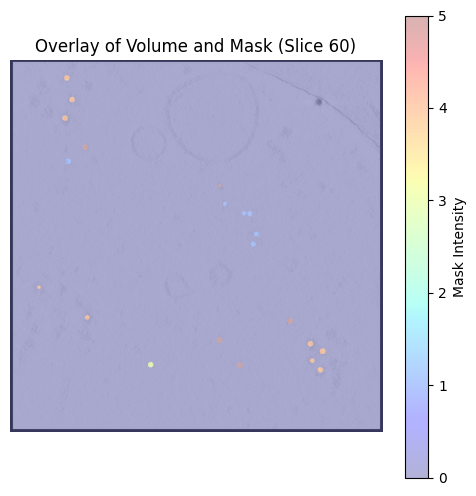

In [7]:
import matplotlib.pyplot as plt

# マスクとボリュームのスライスを取得
slice_index = 60  # 任意のスライスインデックス
mask_slice = mask[slice_index]
volume_slice = volume[slice_index]

# 重ねて表示
plt.figure(figsize=(6, 6))
plt.imshow(volume_slice, cmap='gray', alpha=0.7)  # 背景画像
plt.imshow(mask_slice, cmap='jet', alpha=0.3)    # 重ねるマスク（カラーマップを分ける）
plt.title(f"Overlay of Volume and Mask (Slice {slice_index})")
plt.axis('off')  # 軸を非表示
plt.colorbar(label="Mask Intensity")  # 色の強度を確認できるカラーバーを追加
plt.show()


In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, volume, mask, transform=None):
        self.volume = volume
        self.mask = mask
        self.transform = transform

    def __len__(self):
        return len(self.volume)

    def __getitem__(self, idx):
        volume = self.volume[idx:idx+32]
        mask = self.mask[idx:idx+32]

        volume = torch.from_numpy(volume)
        mask = torch.from_numpy(mask).long()

        if self.transform:
            volume = self.transform(volume)
            mask = self.transform(mask)

        return {'image': volume, 'mask': mask}

In [9]:
dataset = Dataset(volume, mask)
dataLoader = DataLoader(dataset, batch_size=2, shuffle=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

net = Net(pretrained=True,cfg=None)

for batch in dataLoader:
    print(f"Volume dtype: {volume.dtype}, Mask dtype: {mask.dtype}")
    output = net(batch)

    print('batch')
    for k, v in batch.items():
        if k == 'D':
            print(f'{k:>32} : {v} ')
        else:
            print(f'{k:>32} : {v.shape} ')

    print('output')
    for k, v in output.items():
        if 'loss' not in k:
            print(f'{k:>32} : {v.shape} ')
    print('loss')
    for k, v in output.items():
        if 'loss' in k:
            print(f'{k:>32} : {v.item()} ')

    break

cuda
Volume dtype: float16, Mask dtype: int64
batch
                           image : torch.Size([2, 32, 640, 640]) 
                            mask : torch.Size([2, 32, 640, 640]) 
output
                        particle : torch.Size([2, 7, 32, 640, 640]) 
loss
                       mask_loss : 1.8334585428237915 


# 学習の再現

In [11]:
valid_dir = '../input/czii-cryo-et-object-identification/train'
valid_id = ['TS_73_6', ]

In [12]:
net.cuda()
net.eval()
net.output_type = ['loss']

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

submit_df = []
for i,id in enumerate(valid_id):
    print(i, id, '---------------')
    volume = read_one_data(id, static_dir=f'{valid_dir}/static/ExperimentRuns')
    mask = read_one_truth(id, overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')
    mask = generate_mask(mask, mask_size)

    D, H, W = volume.shape
    print(D, H, W)

    d, h, w = mask.shape
    if D != d or H != h or W != w:
        print('mask shape mismatch')
        break

    pad_volume = np.pad(volume, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)
    
    num_slice=16
    zz = list(range(0, D - num_slice, num_slice//2)) + [D - num_slice]

    print('zz:', zz)
    for z in zz:
        print('\r',f'z:{z}', end='',flush=True)
        image = pad_volume[z:z + num_slice]
        mask = pad_volume[z:z + num_slice]

        batch = dotdict(
            image=torch.from_numpy(image).unsqueeze(0),
            mask=torch.from_numpy(mask).unsqueeze(0).long(),
        )
        with torch.amp.autocast('cuda', enabled=True):
            output = net(batch)
            #逆伝播
            loss = output['mask_loss']
            loss.backward()
            #勾配を更新
            optimizer.step()
            optimizer.zero_grad()
        print('')
    
#モデルの保存
torch.save(net.state_dict(), 'model.pth')


0 TS_73_6 ---------------
184 630 630
zz: [0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168]
 z:0
 z:8
 z:16
 z:24
 z:32
 z:40
 z:48
 z:56
 z:64
 z:72
 z:80
 z:88
 z:96
 z:104
 z:112
 z:120
 z:128
 z:136
 z:144
 z:152
 z:160
 z:168


# サブミットの再現

In [18]:
net = Net(pretrained=False, cfg=cfg)
#state_dict = torch.load(cfg.checkpoint, map_location=lambda storage, loc: storage)['state_dict']
# チェックポイントをロード
checkpoint = torch.load(cfg.checkpoint, map_location=lambda storage, loc: storage)

# `state_dict` キーが含まれているか確認
if 'state_dict' in checkpoint:
    # モデルの重みをロード
    state_dict = checkpoint['state_dict']
else:
    # チェックポイントそのものを使用
    state_dict = checkpoint

# モデルにロード
net.load_state_dict(state_dict)


net.cuda()
net.eval()
net.output_type = ['infer']

submit_df = []
for i,id in enumerate(valid_id):
    print(i, id, '---------------')
    volume = read_one_data(id, static_dir=f'{valid_dir}/static/ExperimentRuns')
    D, H, W = volume.shape
    print(D, H, W)

    probability = np.zeros((7, D, H, W), dtype=np.float32)
    count = np.zeros((7, D, H, W), dtype=np.float32)
    pad_volume = np.pad(volume, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)
    
    num_slice=64
    zz = list(range(0, D - num_slice, num_slice//2)) + [D - num_slice]

    print('zz:', zz)
    for z in zz:
        print('\r',f'z:{z}', end='',flush=True)
        image = pad_volume[z:z + num_slice]
        batch = dotdict(
            image=torch.from_numpy(image).unsqueeze(0),
        )
        with torch.amp.autocast('cuda', enabled=True):
            with torch.no_grad():
                output = net(batch)
        prob = output['particle'][0].cpu().numpy()
        probability[:, z:z + num_slice] += prob[:, :, :H, :W]
        count[:, z:z + num_slice] += 1
    probability = probability / (count + 0.0001)
    location = probability_to_location(probability, cfg)
    df = location_to_df(location)
    df.insert(loc=0, column='experiment', value=id)
    submit_df.append(df)
    print('')

print('\ndone!')
num_volume = len(valid_id)
print('')
submit_df = pd.concat(submit_df)
submit_df.insert(loc=0, column='id', value=np.arange(len(submit_df)))



/tmp/ipykernel_3791401/3738969212.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cfg.checkpoint, map_location=lambda storage, loc: storage)


0 TS_73_6 ---------------
184 630 630
zz: [0, 32, 64, 96, 120]
 z:120

done!

